In [1]:
import jax.numpy as jnp
from jax import jit
from functools import partial
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import animation
from IPython.display import HTML
from matplotlib.animation import FFMpegWriter

In [2]:
test = jnp.array([0, 1, 2])
test2 = jnp.full(3, 3)
jnp.concatenate([test, test2])

Array([0, 1, 2, 3, 3, 3], dtype=int32)

In [3]:
class Sperm2D:
    def __init__(self,
                 length: float = 65.0,
                 n_segments: int = 50,
                 bending_modulus: float = 1800.0,
                 amplitude: float = 0.2,
                 wavenumber: float = 1.0,
                 frequency: float = 1.0,
                 phase: float = 0.0,
                 init_position: jnp.ndarray = jnp.array([0.0, 0.0]),
                 init_angle: float = 0.0,
                 head_semi_major: float = 3.0,
                 tail_radius: float = 1.0):
        """
        Initialize a single 2D sperm filament.

        Parameters
        ----------
        length : Total length of the filament (L).
        n_segments : Number of discrete segments (N).
        bending_modulus : Bending stiffness K_B.
        amplitude, wavenumber, frequency, phase : Parameters for the preferred-curvature waveform kappa(s,t).
        init_position : Initial position of the head tip of sperm
        init_angle: Initial angle of the sperm
        head_semi_major, tail_radius: radius of head and flagellum segments
        """
        # Geometry & discretization
        self.L       = length
        self.N_flag  = n_segments
        self.dL      = length / n_segments
        self.a       = head_semi_major
        self.b       = tail_radius

        # radii and segment lengths as JAX arrays
        self.radii   = jnp.concatenate([jnp.array([self.a]),
                                        jnp.full(self.N_flag, self.b)])
        self.lengths = jnp.concatenate([jnp.array([2*self.a]),
                                        jnp.full(self.N_flag, self.dL)])

        # Mechanical parameters
        self.K_B  = bending_modulus
        self.K0   = amplitude
        self.k    = wavenumber
        self.omega = frequency
        self.phi = phase

        # Precompute segment "s" coordinates for preferred curvature
        self.s_mid = jnp.arange(self.dL/2,
                            self.L,
                            self.dL) # shape (N_flag, )

        # midpoint position and angle of each segment including head
        all_coords = jnp.concatenate([
            jnp.array([self.a]),
            self.s_mid + 1.1*self.a
        ])
        self.Y = jnp.stack([
            init_position[0] + all_coords * jnp.cos(init_angle),
            init_position[1] + all_coords * jnp.sin(init_angle)
        ], axis=1)                       # shape (N_flag+1, 2)
        self.thetas = jnp.full(self.N_flag+1, init_angle)
        
        # Lagrange multipliers for N_flag+2 constraints
        self.Lambdas = jnp.zeros((self.N_flag+2, 2))

    @partial(jit, static_argnums=(0,))
    def preferred_curvature(self, t: float) -> jnp.ndarray: # shape (N_flag, )
        """
        Calculate the curvature at midpoints of each flagellum segment, head exclusive.

        Parameters
        ----------
        t : time

        Returns
        -------
        kappa : curvature
        """
        base  = self.K0 * jnp.sin(2*jnp.pi*self.k*self.s_mid/self.L
                                  - self.omega*t + self.phi)
        decay = jnp.where(self.s_mid > self.L/2,
                          1.0,
                          2*self.s_mid/self.L)
        return base * decay

    @partial(jit, static_argnums=(0,))
    def internal_moment(self,
                        theta: jnp.ndarray,   # shape (N_flag+1, )
                        t: float) -> jnp.ndarray: # shape (N_flag+2, )
        """
        Calculate the internal moments at the edge of each segment, head inclusive.

        Parameters
        ----------
        theta : angle at the midpoint of each segment
        t : time

        Returns
        -------
        M : internal moments at segment edges
        """
        kappa = self.preferred_curvature(t)                 # (N_flag, )
        t_hat = jnp.stack([jnp.cos(theta), jnp.sin(theta)], axis=1)  # (N_flag+1, 2)

        # cross product z‐component: t_i × t_{i+1}
        cross = (t_hat[:-1,0]*t_hat[1:,1]
                 - t_hat[:-1,1]*t_hat[1:,0])           # (N_flag, )

        # delta_s for each edge
        delta_s = jnp.concatenate([jnp.array([1.1*self.a+0.5*self.L]),
                                    jnp.full(self.N_flag-1, self.dL)]) # (N_flag, )

        # build M: zeros at boundaries, use vector ops
        M_mid = self.K_B * (cross / delta_s - kappa)    # (N_flag, )
        return jnp.concatenate([jnp.array([0.0]),
                                M_mid,
                                jnp.array([0.0])])  # (N_flag+2,)

    @partial(jit, static_argnums=(0,))
    def reconstruct_midpoints(self,
                              Y1: jnp.ndarray,    # shape (2, )
                              theta: jnp.ndarray      # shape (N_flag+1, )
                              ) -> jnp.ndarray:    # returns (N_flag+1, 2)
        """
        Calculate the midpoint positions of each segment from its angle and the head midpoint position.
    
        Parameters
        ----------
        Y1 : coordinates of the head midpoint
        theta : angle at the midpoint of each segment
    
        Returns
        -------
        Y : midpoint coordinates of each segment
        """
        t_hat = jnp.stack([jnp.cos(theta), jnp.sin(theta)], axis=1)  # (N+1, 2)

        # head-tail and tail-tail displacements
        disp = jnp.vstack([Y1[None, :],
                           0.5*(1.1*self.a+0.5*self.dL)*(t_hat[0] + t_hat[1])[None, :],
                           0.5*self.dL*(t_hat[1:-1]+t_hat[2:])]) # (N+1, 2)

        return jnp.cumsum(disp, axis=0)               # (N+1,2)

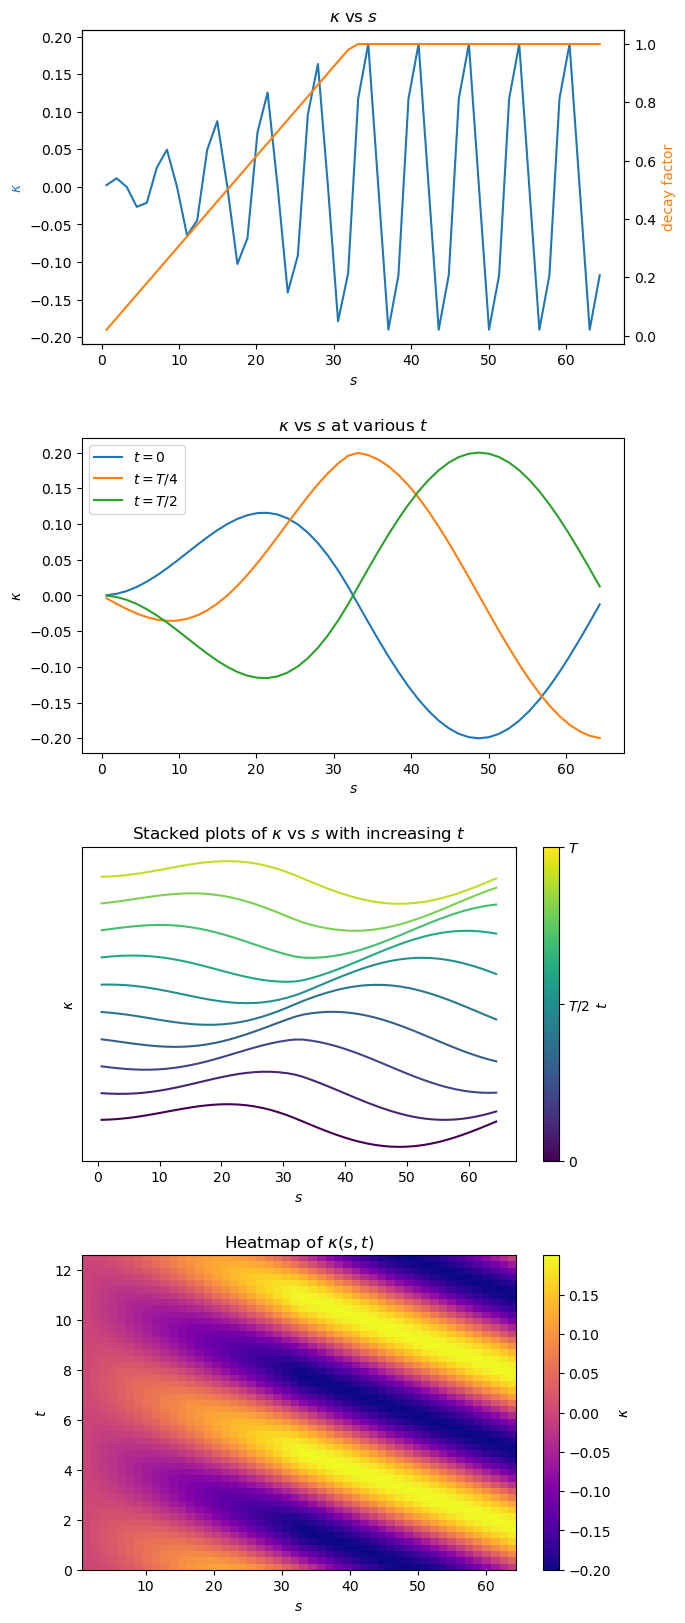

In [6]:
# Check preferred_curvature method
fig, ax = plt.subplots(4, figsize=(7, 20))
plt.subplots_adjust(hspace=0.3)

# Check decay factor
sperm = Sperm2D(wavenumber=10)
kappa = sperm.preferred_curvature(0)
decay = jnp.where(sperm.s_mid > sperm.L/2,
                  1.0,
                  2*sperm.s_mid/sperm.L)
ax[0].plot(sperm.s_mid, kappa)
ax[0].set_title(r'$\kappa$ vs $s$')
ax[0].set_xlabel(r'$s$')
ax[0].set_ylabel(r'$\kappa$', color='C0')
ax1_2 = ax[0].twinx()
ax1_2.plot(sperm.s_mid, decay, label='decay factor', c='C1')
ax1_2.set_ylabel('decay factor', color='C1')

# Different t
sperm = Sperm2D()
T = 2*jnp.pi/sperm.omega
label_list = ['0', 'T/4', 'T/2']
for i in range(3):
    t = i*T/4
    kappa = sperm.preferred_curvature(t)
    ax[1].plot(sperm.s_mid, kappa, label=f"$t={label_list[i]}$")
    ax[1].set_title(r'$\kappa$ vs $s$ at various $t$')
    ax[1].set_xlabel(r'$s$')
    ax[1].set_ylabel(r'$\kappa$')
    ax[1].legend()

# Stacked plots of kappa vs s for various t
T = 2*jnp.pi / sperm.omega    
n_times = 10                 
times = np.linspace(0, T, n_times)
offset = 0.2                  
for i in range(n_times):
    kappa = sperm.preferred_curvature(times[i])
    ax[2].plot(sperm.s_mid, kappa+i*offset, color=plt.cm.viridis(i/n_times))    
ax[2].set_xlabel(r'$s$')
ax[2].set_ylabel(r"$\kappa$")
ax[2].set_yticks([])
ax[2].set_title(r"Stacked plots of $\kappa$ vs $s$ with increasing $t$")
cmap = plt.cm.ScalarMappable(
    cmap='viridis')
cmap.set_array([])
ticks = [0, r'$T/2$', r'$T$']
cbar = fig.colorbar(cmap, ax=ax[2], ticks=[0, 0.5, 1])
cbar.set_label(r'$t$')
cbar.set_ticklabels(['0', r'$T/2$', r'$T$'])

# 2D heatmap of kappa (s, t)
T    = 2*np.pi/sperm.omega
n_t  = sperm.s_mid.shape[0]
times = np.linspace(0, 2*T, n_t)
kappa_array = np.vstack([sperm.preferred_curvature(t).block_until_ready() for t in times])
im = ax[3].imshow(
    kappa_array,
    extent=[sperm.s_mid[0], sperm.s_mid[-1], times[0], times[-1]],
    cmap='plasma',
    aspect='auto'
)
ax[3].set_xlabel(r'$s$')
ax[3].set_ylabel(r'$t$')
ax[3].set_title(r'Heatmap of $\kappa(s,t)$')
cbar = fig.colorbar(im, ax=ax[3])
cbar.set_label(r'$\kappa$')

plt.show()

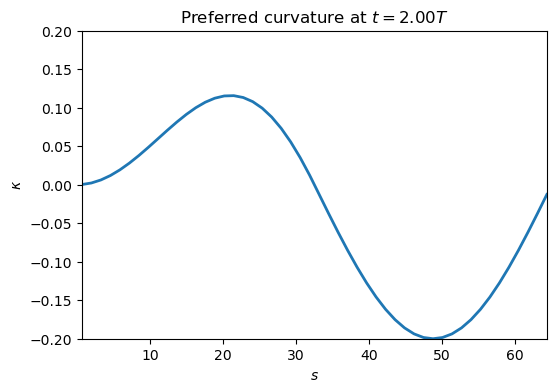

In [5]:
# Animate the data from 2D heatmap of kappa
fig, ax = plt.subplots(figsize=(6,4))
ax.set_xlim(sperm.s_mid[0], sperm.s_mid[-1])
ax.set_ylim(-sperm.K0, sperm.K0)
ax.set_xlabel(r'$s$')
ax.set_ylabel(r'$\kappa$')

line, = ax.plot([], [], lw=2)
title = ax.set_title('')

def init():
    line.set_data([], [])
    return (line, title)

def animate(i):
    line.set_data(sperm.s_mid, kappa_array[i])
    title.set_text(f'Preferred curvature at $t={times[i]/T:.2f}T$')
    return (line, title)

ani = animation.FuncAnimation(
    fig, animate, init_func=init,
    frames=len(times), interval=100, blit=True
)

writer = FFMpegWriter(
    fps=10,
    metadata=dict(title='kappa vs s with increasing t'),
    bitrate=1800
)

ani.save('kappa_s_t.mp4', writer=writer, dpi=200)

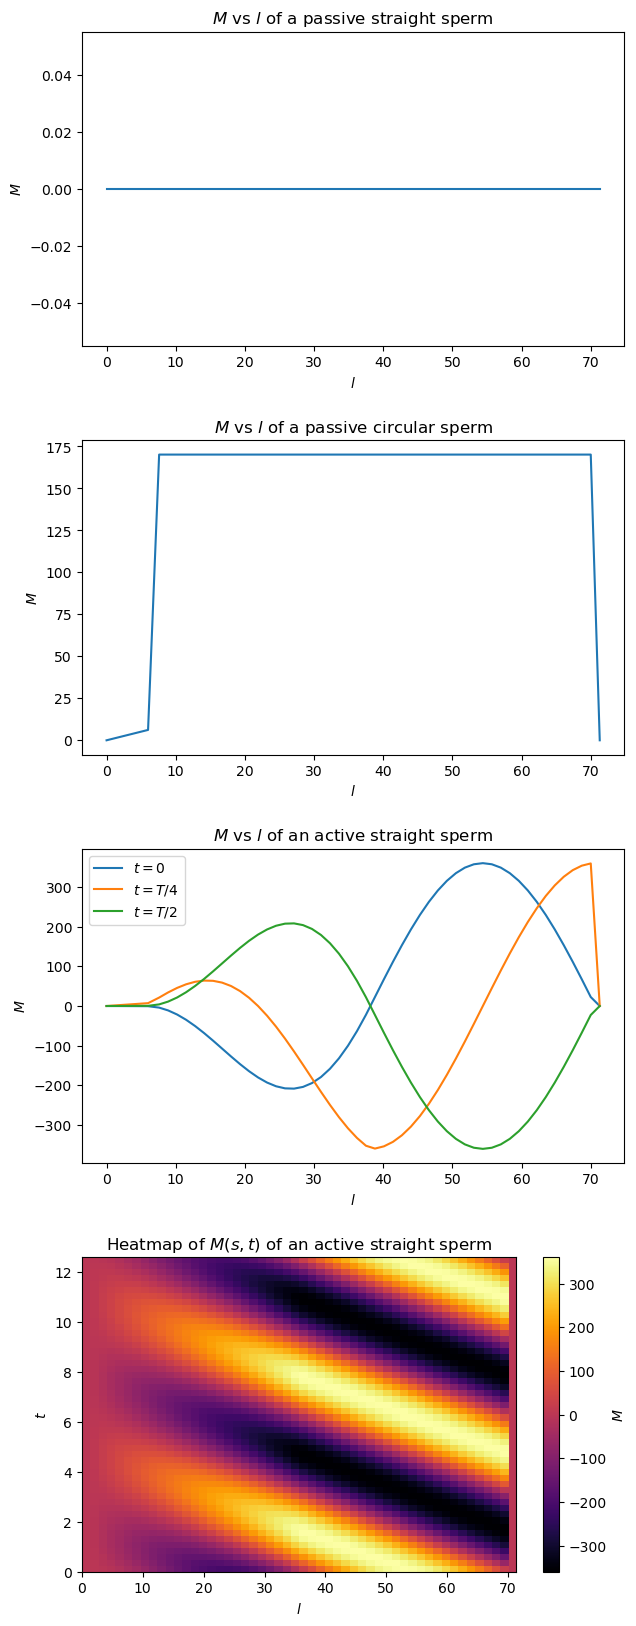

In [24]:
# Check internal_moment method
fig, ax = plt.subplots(4, figsize=(7, 20))
plt.subplots_adjust(hspace=0.3)

# Passive straight sperm
sperm = Sperm2D(amplitude=0)
l = jnp.concatenate([jnp.array([0.0, 2*sperm.a]),
                     jnp.arange(2.1*sperm.a+sperm.dL, 2.1*sperm.a+sperm.L+sperm.dL, sperm.dL)])
M = sperm.internal_moment(sperm.thetas, 0)
ax[0].plot(l, M)
ax[0].set_title(r'$M$ vs $l$ of a passive straight sperm')
ax[0].set_xlabel(r'$l$')
ax[0].set_ylabel(r'$M$')

# Passive circular sperm
sperm.thetas = jnp.linspace(0, 2*np.pi, sperm.thetas.shape[0], endpoint=False)
M = sperm.internal_moment(sperm.thetas, 0)
ax[1].plot(l, M)
ax[1].set_title(r'$M$ vs $l$ of a passive circular sperm')
ax[1].set_xlabel(r'$l$')
ax[1].set_ylabel(r'$M$')

# Active straight sperm at different times
sperm = Sperm2D()
T = 2*jnp.pi/sperm.omega
label_list = ['0', 'T/4', 'T/2']
for i in range(3):
    t = i*T/4
    M = sperm.internal_moment(sperm.thetas, t)
    ax[2].plot(l, M, label=f'$t={label_list[i]}$')
ax[2].set_title(r'$M$ vs $l$ of an active straight sperm')
ax[2].set_xlabel(r'$l$')
ax[2].set_ylabel(r'$M$')
ax[2].legend()

# 2D heatmap of M (s, t) of an active straight sperm
T    = 2*np.pi/sperm.omega
n_t  = l.shape[0]
times = np.linspace(0, 2*T, n_t)
M_array = np.vstack([sperm.internal_moment(sperm.thetas, t).block_until_ready() for t in times])
im = ax[3].imshow(
    M_array,
    extent=[l[0], l[-1], times[0], times[-1]],
    cmap='inferno',
    aspect='auto'
)
ax[3].set_xlabel(r'$l$')
ax[3].set_ylabel(r'$t$')
ax[3].set_title(r'Heatmap of $M(s,t)$ of an active straight sperm')
cbar = fig.colorbar(im, ax=ax[3])
cbar.set_label(r'$M$')

plt.show()

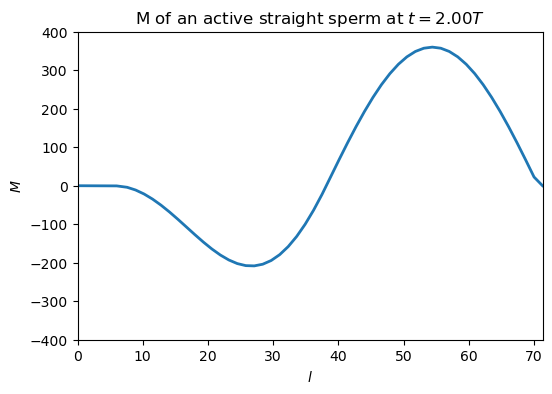

In [28]:
# Animate the data from 2D heatmap
fig, ax = plt.subplots(figsize=(6,4))
ax.set_xlim(l[0], l[-1])
ax.set_ylim(-400, 400)
ax.set_xlabel(r'$l$')
ax.set_ylabel(r'$M$')

line, = ax.plot([], [], lw=2)
title = ax.set_title('')

def init():
    line.set_data([], [])
    return (line, title)

def animate(i):
    line.set_data(l, M_array[i])
    title.set_text(f'M of an active straight sperm at $t={times[i]/T:.2f}T$')
    return (line, title)

ani = animation.FuncAnimation(
    fig, animate, init_func=init,
    frames=len(times), interval=100, blit=True
)

writer = FFMpegWriter(
    fps=10,
    metadata=dict(title='M vs l of an active straight sperm with increasing t'),
    bitrate=1800
)

ani.save('M_l_t.mp4', writer=writer, dpi=200)